# Importations

In [416]:
pip install imageio

Note: you may need to restart the kernel to use updated packages.


In [417]:
pip install -U scikit-image

Requirement already up-to-date: scikit-image in /opt/anaconda3/lib/python3.7/site-packages (0.17.2)
Note: you may need to restart the kernel to use updated packages.


In [418]:
import imageio
import numpy
from matplotlib.pyplot import *
from skimage import filters
import mrlab as mr
import matplotlib.pyplot as plt

import skimage.morphology as morpho  
import skimage.feature as skf
from scipy import ndimage as ndi

from skimage.morphology import label


# Importation des images

In [419]:
bat = imread('bat.bmp')

lena = imread('lena.tif')

im2 = imread('paysage.jpg')
grand_paysage =im2[:,:,2]

im3 = imread('photo.png')
petit_paysage =im3[:,:,2]

# Gradients

In [420]:
def gradient_sobel(im,sigma,seuilnorme):  #sigma=0  seuilnorme=0.3
    gfima=filters.gaussian(im,sigma)
    gradx=mr.sobelGradX(gfima)
    grady=mr.sobelGradY(gfima)

    norme=np.sqrt(gradx*gradx+grady*grady)
    return(norme)

def gradient_morpho(im):
    se = se=morpho.selem.disk(1)

    return morpho.dilation(im,se)-morpho.erosion(im,se)

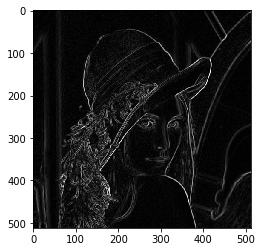

In [421]:
sobel_lena = gradient_sobel(lena, 0, 0.3)
plt.imshow(grad, cmap = 'gray')

# Création cellules

In [422]:
def taille_bande_separante(test,taille_cellule):
    n=0
    m=taille_cellule
    while test[n][taille_cellule//2]>0:
        n+=1
    while test[m][0]>0:
        m-=1
    return(m-n)
    



#taille_cellule est le nombre de pixels que l'on veut par cellule
def creation_cellules(im,taille_cellule, bande_separante_min):
    n,m=np.shape(im)[0],np.shape(im)[1]
    M=np.zeros((n,m))
    
    for i in range(1,n//taille_cellule):                             #cette boucle sert à mettre des points tout à gauche, et tout à droite
        if i%2==0:
            M[i*taille_cellule][taille_cellule//2]=255
        else :
            M[i*taille_cellule][0],M[i*taille_cellule][m-1]=255,255
            
    for j in range(m//taille_cellule):
            M[0][j*taille_cellule+taille_cellule//2],M[n-1][j*taille_cellule+taille_cellule//2] = 255,255

    for i in range(1,n//taille_cellule):
        for j in range(1,m//taille_cellule):
            if i%2==0:
                M[i*taille_cellule][j*taille_cellule+taille_cellule//2]=255
            else:
                M[i*taille_cellule][j*taille_cellule]=255
                
    #dilatation de M:
    se=[[0,1,1,1,0],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[0,1,1,1,0]] #cet élément structurant est un hexagone

    test=M
    k=0
    t=(taille_bande_separante(test,taille_cellule)>=bande_separante_min)
    while (t):
        test=morpho.dilation(test,se)
        t=(taille_bande_separante(test,taille_cellule)>=bande_separante_min)
        k+=1
    
    for i in range(k-1):
        M=morpho.dilation(M,se) 
    
    #S=superposition(im,M)
    return M


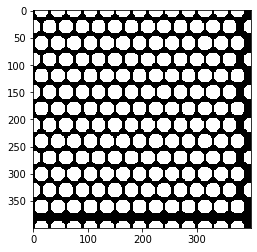

In [423]:
bande_separante_min=2
taille_cellule = 30
M=creation_cellules(petit_paysage,taille_cellule,bande_separante_min)
plt.imshow(M,cmap='gray')

# Minimum du gradient

In [424]:
from collections import Counter


def min_grad(grad,taille_cellule,bande_separante_min): 
    M = creation_cellules(grad,taille_cellule,bande_separante_min)
    n,m = np.shape(grad)
    label1 = label(M)
    min_grad = 0*np.ones((n,m))
    norme = grad
    
    index = []
    
    for k in range(1,np.max(label1)):
        im_tmp = 0*np.ones((n,m))
        for i in range(n):
            for j in range(m):
                if label1[i][j] == k:
                    im_tmp[i][j] = norme[i][j]
                    index.append([i,j])
        
        if im_tmp.max()==0:
            idx_min = index[0]
            idx_max = index[-1]
            a = int((idx_min[0]+idx_max[0])/2)
            b = int((idx_min[1]+idx_max[1])/2)
            min_grad[a,b] = 255
            
            
        else :
            minimum = np.min(im_tmp[np.nonzero(im_tmp)])
            tmp2 = 0*np.ones((n,m))
        
        
            for i in range(n):
                for j in range(m):
                    if im_tmp[i][j] == minimum:
                        tmp2[i][j] = 255
                        
                        
            label2 = label(tmp2)
            label2_whithout_zero = []
    
            for i in range(n):
                for j in range(m):
                    if label2[i][j] != 0:
                        label2_whithout_zero.append(label2[i][j])
                        
            mostcommon = Counter(label2_whithout_zero).most_common(1)
    
            for i in range(n):
                for j in range(m):
                    if label2[i][j] == mostcommon[0][0]:
                        min_grad[i][j] = 255
                        
        
                    
    return min_grad
                



# Carte de distance


In [425]:
def distance_map(im_bin,mask):   #avec mask='4-connexité', mask='8-connexité 3-4', ou mask='8-connexité 5-7-11'
    n,m=len(im_bin),len(im_bin[0])
    bina=np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            if im_bin[i][j]==0:
                bina[i][j]=1000
            else:
                bina[i][j]=0
    bina2=bina
    if mask=='4-connexité':
        dist=np.zeros((n,m))          
        for i in range(1,n):
            for j in range(1,m):
                L=[bina[i-1][j]+1,bina[i][j-1]+1,bina[i][j]]
                dist[i][j]=np.min(L)
                bina[i][j]=dist[i][j]


        for i in range(n-2,-2,-1):
            for j in range(m-2,-2,-1):
                L=[bina2[i+1][j]+1,bina2[i][j+1]+1,bina2[i][j]]
                dist[i][j]=np.min(L)
                bina2[i][j]=dist[i][j]

    elif mask=='8-connexité 3-4':
        
        dist=np.zeros((n,m))          
        for i in range(1,n):
            for j in range(1,m-1):
                L=[bina[i-1][j-1]+4,bina[i][j-1]+3,bina[i-1][j]+3,bina[i-1][j+1]+4,bina[i][j]]
                dist[i][j]=np.min(L)
                bina[i][j]=dist[i][j]


        for i in range(n-2,-2,-1):
            for j in range(m-2,-1,-1):
                L=[bina2[i+1][j+1]+4,bina2[i][j+1]+3,bina2[i+1][j]+3,bina2[i+1][j-1]+4,bina2[i][j]]
                dist[i][j]=np.min(L)
                bina2[i][j]=dist[i][j]
    elif mask=='8-connexité 5-7-11':
        dist=np.zeros((n,m))          
        for i in range(2,n):
            for j in range(2,m-2):
                L=[bina[i-1][j-1]+7,bina[i][j-1]+5,bina[i-1][j]+5,bina[i-1][j+1]+7,bina[i-1][j+2]+11,bina[i-2][j+1]+11,bina[i-1][j-2]+11,bina[i-2][j-1]+11,bina[i][j]]
                dist[i][j]=np.min(L)
                bina[i][j]=dist[i][j]


        for i in range(n-3,-1,-1):
            for j in range(m-3,1,-1):
                L=[bina2[i+1][j+1]+7,bina2[i][j+1]+5,bina2[i+1][j]+5,bina2[i+1][j-1]+7,bina2[i+1][j-2]+11,bina2[i+2][j-1]+11,bina2[i+1][j+2]+11,bina2[i+2][j+1]+11,bina2[i][j]]
                dist[i][j]=np.min(L)
                bina2[i][j]=dist[i][j]
    return(dist)


# Régularisation

In [426]:
def grag_reg(grad, distmap, k,taille_cellule):
    n,m = np.shape(grad)
    res = 0*np.ones((n,m))
    for i in range(n):
        for j in range(m):
            res[i][j] = grad[i][j]+k*(2*distmap[i][j])/taille_cellule
    return res



# Watershed

In [427]:
def couleurs_alea(im):
    """ 
    Donne des couleurs aleatoires a une image en niveau de gris.
    Cette fonction est utile lorsque le niveua de gris d'interprete comme un numero
      de region. Ou encore pour voir les leger degrades d'une teinte de gris.
      """
    sh=im.shape
    out=np.zeros((sh[0],sh[1],3),dtype=np.uint8)
    nbcoul=np.int32(im.max())
    tabcoul=np.random.randint(0,256,size=(nbcoul+1,3))
    tabcoul[0,:]=0
    for k in range(sh[0]):
        for l in range(sh[1]):
            out[k,l,:]=tabcoul[im[k,l]]
    return out


def watershed(im,grad,dist_map,min_grad,k,taille_cellule):
    gradnorm=grag_reg(grad, dist_map, k,taille_cellule)
    local_mini = skf.peak_local_max(min_grad,indices=False)
    markers = ndi.label(local_mini)[0]
    labels = morpho.watershed(gradnorm, markers,watershed_line=True)
    segm=labels.copy()
    for i in range(segm.shape[0]):
        for j in range(segm.shape[1]):
            if segm[i,j] == 0: 
                segm[i,j]=255
            else:
                segm[i,j]=0
    #superposition des contours de la segmentation a l'image initiale
    contourSup=np.maximum(segm,im)
    return(contourSup)

# Tests

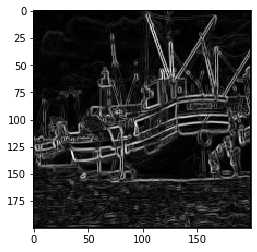

In [428]:
sobel_bat = gradient_sobel(bat,0,0.3)
plt.imshow(sobel_bat, cmap = 'gray')

morpho_bat = gradient_morpho(bat)

In [429]:
A = creation_cellules(bat,20,2)

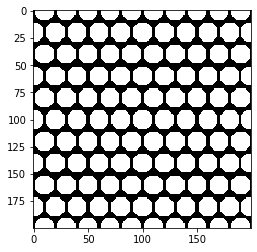

In [430]:
plt.imshow(A, cmap='gray')

In [431]:
min_grad_bat = min_grad(morpho_bat,20,2)

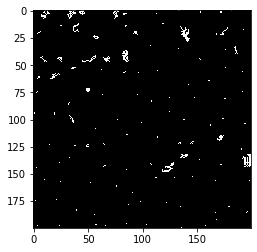

In [432]:
plt.imshow(min_grad_bat,cmap='gray')

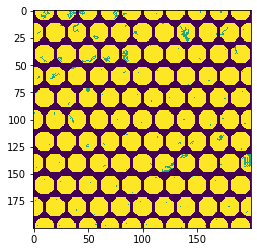

In [433]:
cells = creation_cellules(bat,20,2)


for i in range(200):
    for j in range(200):
        if min_grad_bat[i][j] == 255:
            cells[i][j] = 150
            
plt.imshow(cells)

In [434]:
distance_bat = distance_map(min_grad_bat,mask='8-connexité 5-7-11')

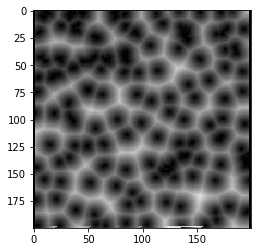

In [435]:
plt.imshow(distance_bat,cmap='gray')

In [437]:
g_reg_bat = grag_reg(morpho_bat, distance_bat, 10,20)

In [439]:
waterpixel_bat = watershed(bat,morpho_bat,distance_bat,min_grad_bat,10,20)

/opt/anaconda3/lib/python3.7/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


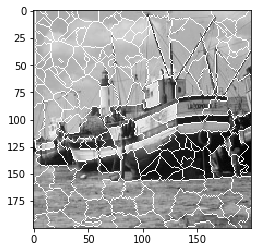

In [441]:
plt.imshow(waterpixel_bat,cmap='gray')

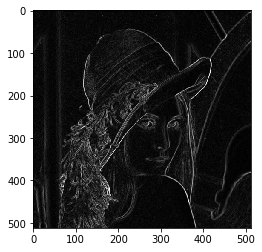

In [442]:
morpho_lena = gradient_morpho(lena)
plt.imshow(morpho_lena, cmap = 'gray')

In [443]:
min_grad_lena = min_grad(morpho_lena,32,2)

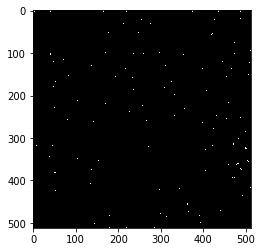

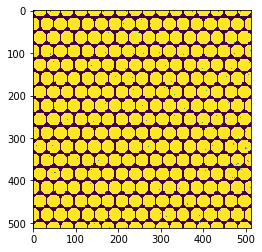

In [444]:
n,m = np.shape(lena)

for i in range(n):
    for j in range(m):
        if min_grad_lena[i][j] == 255:
            cells2[i][j] = 150


plt.figure()
plt.imshow(min_grad_lena, cmap = 'gray')
plt.figure()
plt.imshow(cells2)

In [453]:
distance_lena = distance_map(min_grad_lena,mask='8-connexité 5-7-11')

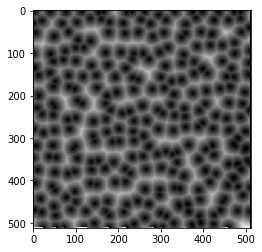

In [454]:
plt.imshow(distance_lena,cmap='gray')

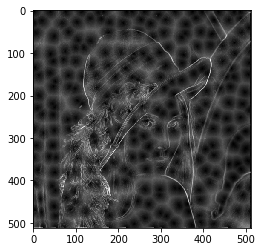

In [457]:
g_reg_lena = grag_reg(morpho_lena, distance_lena, 10, 32)
plt.imshow(g_reg_lena, cmap='gray')

In [458]:
waterpixel_lena = watershed(lena,morpho_lena,distance_lena,min_grad_lena,10,32)

/opt/anaconda3/lib/python3.7/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


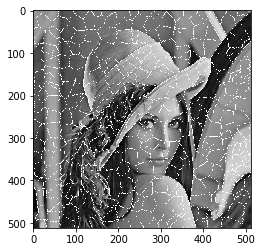

In [459]:
plt.imshow(waterpixel_lena,cmap='gray')